# Import Configuration

In [114]:
import glob
import json
import multiprocessing.dummy as multiprocessing
import os
import os.path as osp
import sys
import random
import re
import skimage
import colorsys
from collections import defaultdict
import numpy as np
import skimage.draw
from skimage import io
import matplotlib
from skimage.measure import find_contours
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
if "DISPLAY" not in os.environ:
    plt.switch_backend('agg')
print(matplotlib.get_backend())

import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

import cv2
from shapely.geometry import MultiPoint, Point, Polygon
import numpy as np
import skimage.transform as transform
# import torch
# from torch.utils.data import Dataset
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from utils import utils_inspect as utils

from config import Config

%matplotlib inline

TkAgg


## Plot Settings

In [115]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

In [116]:
def add_image(image_id, path, **kwargs):
    image_info = {
        "id": image_id,
        "path": path,
    }
    image_info.update(kwargs)
    image_info.append(image_info)

def load_image(image_path):
    """Load the specified image and return a [H,W,3] Numpy array.
    """
    # Load image
    image = skimage.io.imread(image_path)
    # If grayscale. Convert to RGB for consistency.
    if image.ndim != 3:
        image = skimage.color.gray2rgb(image)
    return image

In [117]:
class BuildingConfig(Config.General_Config):
    # Give the configuration a recognizable name
    NAME = "building"

    # We use one GPU with 8GB memory, which can fit one image.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1

    # steps per epoch
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 80

    PNUM = 16
    CP_NUM = 16

    NUM_WORKERS = 4
    BATCH_SIZE = 1

# Dataset Path

In [118]:
# Dataset directory
dataset_path = '/home/kang/BuildingDetection/data/Train_Test/AOI_2_Vegas_Train/select'
split = 'train'
config = BuildingConfig()
# Inference Configuration
# config = nucleus.NucleusInferenceConfig()
# config.display()

# Read raw data from files

In [119]:
dataset_dir = os.path.join(dataset_path, split)
anno_list = glob.glob(osp.join(dataset_dir, '*.json'))
with open(anno_list[0], 'r') as f:
    annotations = json.load(f)
height = 650
width = 650
polygons = []
image_infos = []

i = 0
for a in annotations:
# Get the x, y coordinaets of points of the polygons that make up
# the outline of each object instance. There are stores in the
# shape_attributes (see json format above)
# polygons = [r['shape_attributes'] for r in a['regions'].values()]
    if a['BuildingId'] != '1':
        poly = {}.fromkeys(['x', 'y'])
        poly['building_id'] = i+1
        x = [float(s) for s in re.findall(r'-?\d+\.?\d*', a['X'])]
        y = [float(s) for s in re.findall(r'-?\d+\.?\d*', a['Y'])]
        for k, t in enumerate(x):
            if (t >= 650):
                x[k] = 649.5
        for k, t in enumerate(y):
            if (t >= 650):
                y[k] = 649.5
        poly['x'] = x
        poly['y'] = y
        if (len(x) == 0 | len(y) == 0):
            continue
        elif (len(x) > 25):
            continue
        elif (np.size(x, 0) < 2 | np.size(y, 0) < 2):
            continue
        elif ((np.abs(np.max(x) - np.min(x)) < 7) | (np.abs(np.max(y) - np.min(y)) < 7)):
            continue
        else:
            polygons.append(poly)
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            filename = 'RGB-PanSharpen_' + a['ImageId'] + '.tif'
            image_path = os.path.join(dataset_dir, filename)
            # image = skimage.io.imread(image_path)
            # height, width = image.shape[:2]
            height = 650
            width = 650
            i = i+1
    else:
        if ((polygons != [])):
#             add_image(
#                 image_id=filename,  # use file name as a unique image id
#                 path=image_path,
#                 width=width, height=height,
#                 polygons=polygons)
            image_info = defaultdict(float)
            image_info['image_id'] = filename
            image_info['path'] = image_path
            image_info['polygons'] = polygons
            image_infos.append(image_info)
            i = 0
        flag = 0
        polygons = []
        poly = {}.fromkeys(['x', 'y', 'building_id'])
        poly['building_id'] = i+1
        x = [float(s) for s in re.findall(r'-?\d+\.?\d*', a['X'])]
        y = [float(s) for s in re.findall(r'-?\d+\.?\d*', a['Y'])]
        for k, t in enumerate(x):
            if(t >= 650):
                x[k] = 649.5
        for k, t in enumerate(y):
            if(t >= 650):
                y[k] = 649.5
        poly['x'] = x
        poly['y'] = y
        if (len(x) == 0 | len(y) == 0):
            flag = 1
            continue
        elif (len(x) > 25):
            continue
        elif (np.size(x, 0) < 2 | np.size(y, 0) < 2):
            flag = 1
            continue
        elif ((np.abs(np.max(x) - np.min(x)) < 7) | (np.abs(np.max(y) - np.min(y)) < 7)):
            flag = 1
            continue
        else:
            polygons.append(poly)
            filename = 'RGB-PanSharpen_' + a['ImageId'] + '.tif'
            image_path = os.path.join(dataset_dir, filename)
            # image = skimage.io.imread(image_path)
            # height, width = image.shape[:2]
            height = 650
            width = 650
            i = i+1
            
print(i)


0


# Add parameters

In [120]:
context_expansion = config.CONTEXT_EXPANSION
class_info = [{"id": 0, "name": "BG"}, {"id": 1, "name": "building"}]
num_classes = len(class_info)
class_ids = np.arange(num_classes)
class_ids[:] = 1
class_names = [c["name"] for c in class_info]
num_images = len(image_infos)
image_ids = np.arange(num_images)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                         config.RPN_ANCHOR_RATIOS,
                                         config.BACKBONE_SHAPES,
                                         config.BACKBONE_STRIDES,
                                         config.RPN_ANCHOR_STRIDE)
print(num_images)

6


# Load Image

5
/home/kang/BuildingDetection/data/Train_Test/AOI_2_Vegas_Train/select/train/RGB-PanSharpen_AOI_2_Vegas_img4016.tif


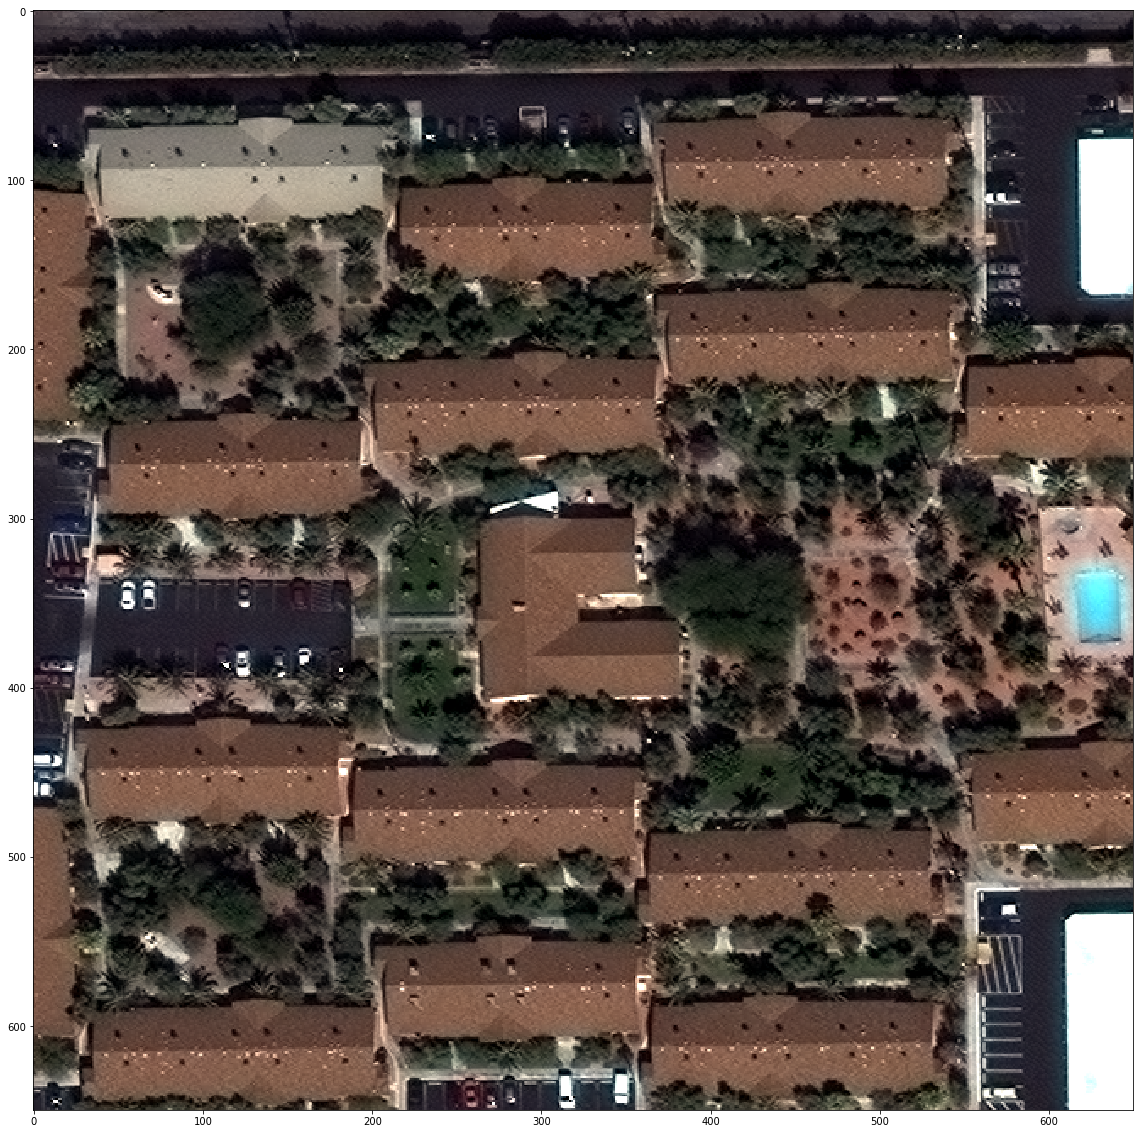

In [121]:
# idx = random.choice(image_ids)
# idx = 1677
idx = 5
img_info = image_infos[idx]
image_path = img_info['path']
image_id = img_info['image_id']
gt_image = load_image(image_path)
ax = get_ax()
ax.imshow(gt_image)
plt.show
print(idx)
print(image_path)

# Polygons Settings

In [122]:
instances = img_info['polygons']
shape = gt_image.shape
image, window, scale, padding = utils.resize_image(
    gt_image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    padding=config.IMAGE_PADDING)
full_masks = np.zeros([image.shape[0], image.shape[1], len(instances)],
                      dtype=np.uint8)
vertex_masks = np.zeros((28, 28, len(instances)), np.float32)
edge_masks = np.zeros((28, 28, len(instances)), np.float32)
masks = np.zeros((28, 28, len(instances)), np.float32)
poly_id = np.zeros(len(instances), np.int)
pnum = 16
cp_num = 16
gt_polys = np.zeros((pnum, 2, len(instances)), np.float32)    #
pointsnp = np.zeros((cp_num, 2, len(instances)), np.float32)  # initial circle points
image_meta = utils.compose_image_meta(shape, window)
bboxes = np.zeros((len(instances), 4), np.int32)
square_boxes = np.zeros((len(instances), 4), np.int32)
nor_polys = np.zeros((pnum, 2, len(instances)), np.float32)  #normalized gt points after sampling
masked_image = image.astype(np.uint8).copy()
masked_image1 = image.astype(np.uint8).copy()
masked_image2 = image.astype(np.uint8).copy()

N = len(instances)

colors = utils.random_colors(N)




/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:479: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


# Process Polygons

In [123]:
for i, poly in enumerate(instances):
    poly_id[i] = poly['building_id']
    xs_wise = np.asarray(poly['x'])
    ys_wise = np.asarray(poly['y'])

    #to change clockwise or counter-clockwise: need to observe the points first
    #here traininig points and val points are different direction
    if split == 'val':
        x = xs_wise[::-1]
        y = ys_wise[::-1]
    else:
        x = xs_wise
        y = ys_wise
    poly_points = np.zeros((len(x), 2), dtype=float)
    poly_points[:, 0] = x
    poly_points[:, 1] = y

    orig_poly_point = (np.floor(poly_points.copy())).astype(np.int32)
    orig_gt_point = poly_points.copy()
    # get bboxes
    gt_poly = utils.resize_point(orig_gt_point, scale, padding)  #resize points to (1024, 1024) scale
    # gt_polys[:,:,i] = gt_poly
    bboxes[i, :] = utils.extract_single_box(gt_poly)

    # square_boxes[i, :], gt_spoly, poly_info = utils.extract_single_sbox(gt_poly, self.context_expansion)
    # resize points
    nor_poly_gt = utils.minimize_poly_point(bboxes[i, :], gt_poly)
    nor_grid_poly = utils.poly01_to_poly0g(nor_poly_gt, 28)
    # get region mask
    edge_mask = np.zeros((28, 28), np.float32)
    vertex_masks[:, :, i] = utils.get_mini_vertices_mask(nor_grid_poly, vertex_masks[:, :, i])
    edge_masks[:, :, i] = utils.get_mini_edge_mask(nor_grid_poly, edge_mask.copy())
    mask = np.zeros((28, 28), np.float32)
    masks[:, :, i] = utils.get_mini_full_mask(nor_grid_poly, mask.copy())

    mask = utils.load_mask(gt_poly[:, 0], gt_poly[:, 1])
    full_masks[:, :, i] = mask
    ori_masks = utils.minimize_single_mask(bboxes[i,:], full_masks[:, :, i], [28, 28])

    # get vertex and boundary edge mask
    # edge_mask = np.zeros((self.height, self.width), np.float32)
    # vertex_masks[:, :, i] = utils.get_vertices_mask(orig_poly_point, vertex_masks[:, :, i])
    # edge_masks[:, :, i] = utils.get_edge_mask(orig_poly_point, edge_mask.copy())

    # resample the points to the same N number
    arr_gt_poly = np.ones((pnum, 2), np.float32) * 0.
    gt_poly1 = utils.uniformsample(nor_poly_gt, newpnum=pnum)
    arr_gt_poly[:, :] = gt_poly1
    nor_polys[:, :, i] = arr_gt_poly
    # get initial cvircle points for gragh (normalized)
    pointsnp[:, :, i] = utils.get_initial_points(cp_num=cp_num)

    y1, x1, y2, x2 = bboxes.copy()[i, :]
    h = y2 -y1
    w = x2 -x1
    x_c = ((x2 + x1)/2 - x1)/w
    y_c = ((y2 + y1)/2 - y1)/h
    # nor_polys[:, 0, i] = nor_polys[:, 0, i] - y_c
    # nor_polys[:, 1, i] = nor_polys[:, 1, i] - x_cs
    
#     img = image[y1:y2, x1:x2]
#     image.astype(np.float32)
    img = utils.minimize_single_mask(bboxes[i,:], image[:, :, 0], [28, 28])
    img.astype(np.uint8)

    gt_poly_test = arr_gt_poly.copy()
    gt_poly_test[:, 1] = gt_poly_test[:, 1] * h + y1
    gt_poly_test[:, 0] = gt_poly_test[:, 0] * w + x1
    masked_image = utils.draw_poly(masked_image, gt_poly, masked_image, color=0)
    masked_image1 = utils.draw_box(masked_image1, bboxes[i], color=0)
    
    color1 = colors[i]
    masked_image2 = utils.apply_mask(masked_image2, full_masks[:,:,i], color1)

    pred_mask = edge_masks[:, :, i].copy()
    pred_mask = pred_mask.astype(np.int8)
    
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
#     ax1.imshow(img)
#     ax2.imshow(ori_masks)
#     ax3.imshow(masks[:, :, i])
#     plt.show()
    
#     figure1 = (16, 16)
#     figsize = (16, 16)
#     plt.figure(figsize=figsize)
#     plt.imshow(pred_mask)
#     plt.show(0)
    
#     plt.imshow(img)
#     plt.show
#     pred_mask = skimage.transform.resize(pred_mask, [h, w], order=1, mode="reflect")

#     pred_mask = utils.draw_poly(pred_mask, gt_poly, pred_mask, color=0)





/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


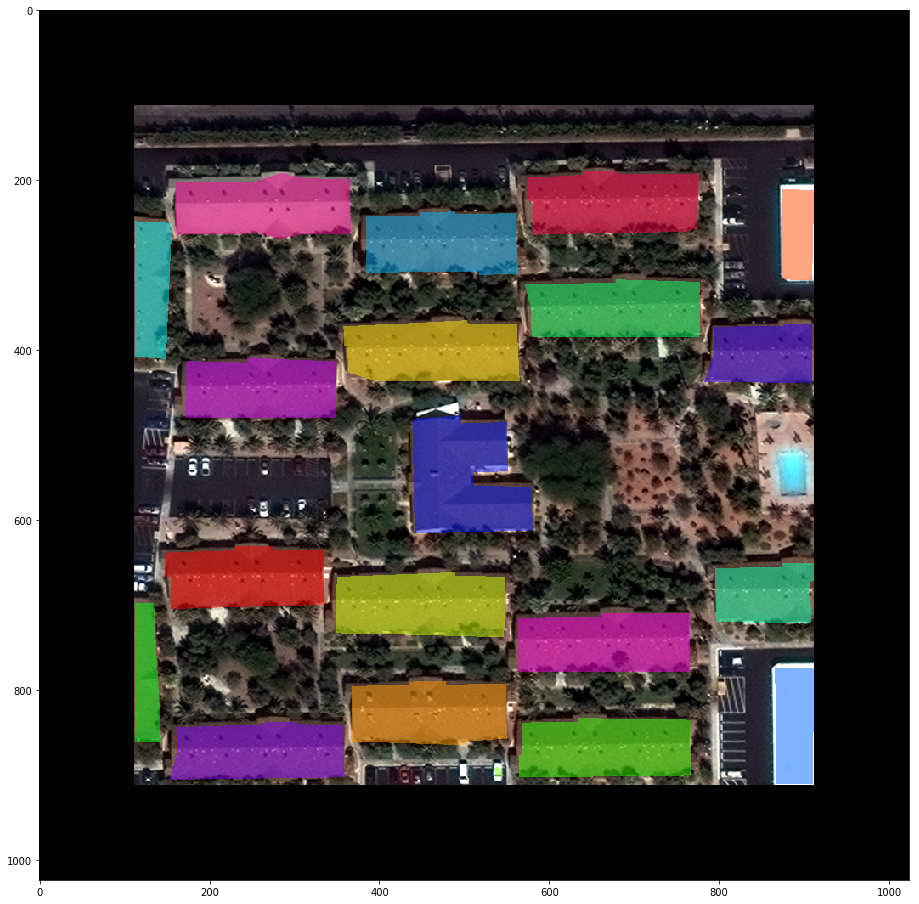

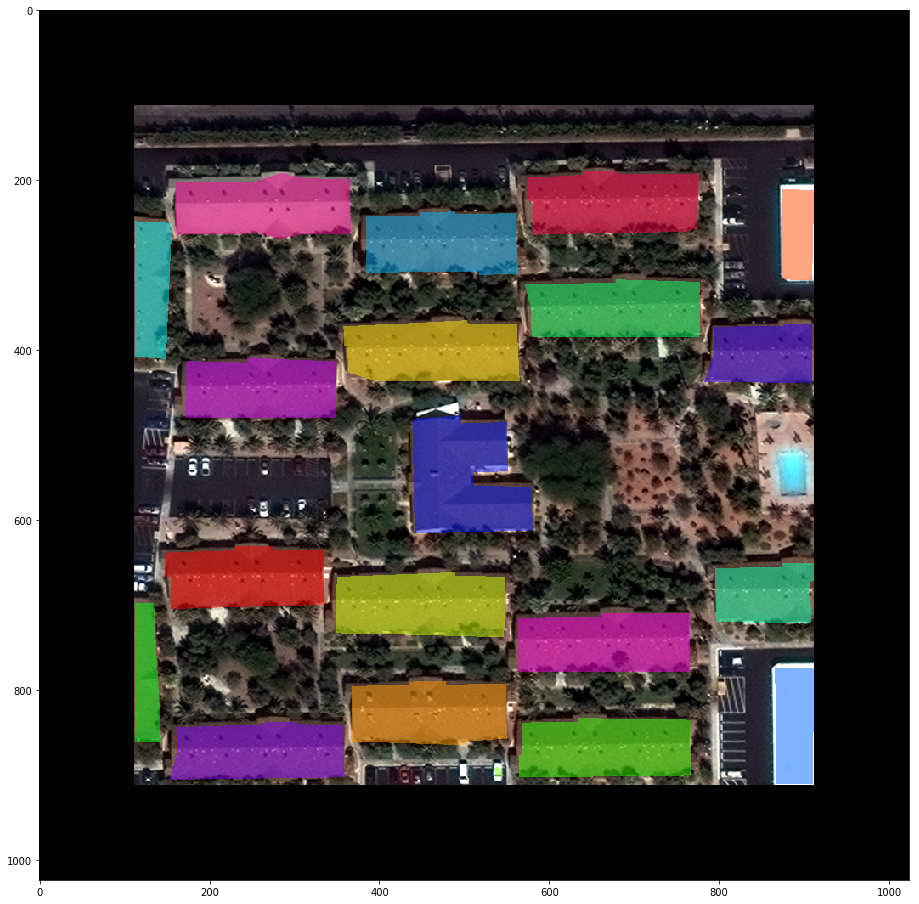

In [124]:
figsize = (16, 16)
plt.figure(figsize=figsize)
plt.imshow(masked_image2)
plt.show(0)
output = "/home/kang/BuildingDetection/data/Train_Test/AOI_2_Vegas_Train/theis_vis_all/"
output_path_image = output + image_id
skimage.io.imsave(output_path_image+"_mask.jpg", masked_image2.astype(np.uint8))

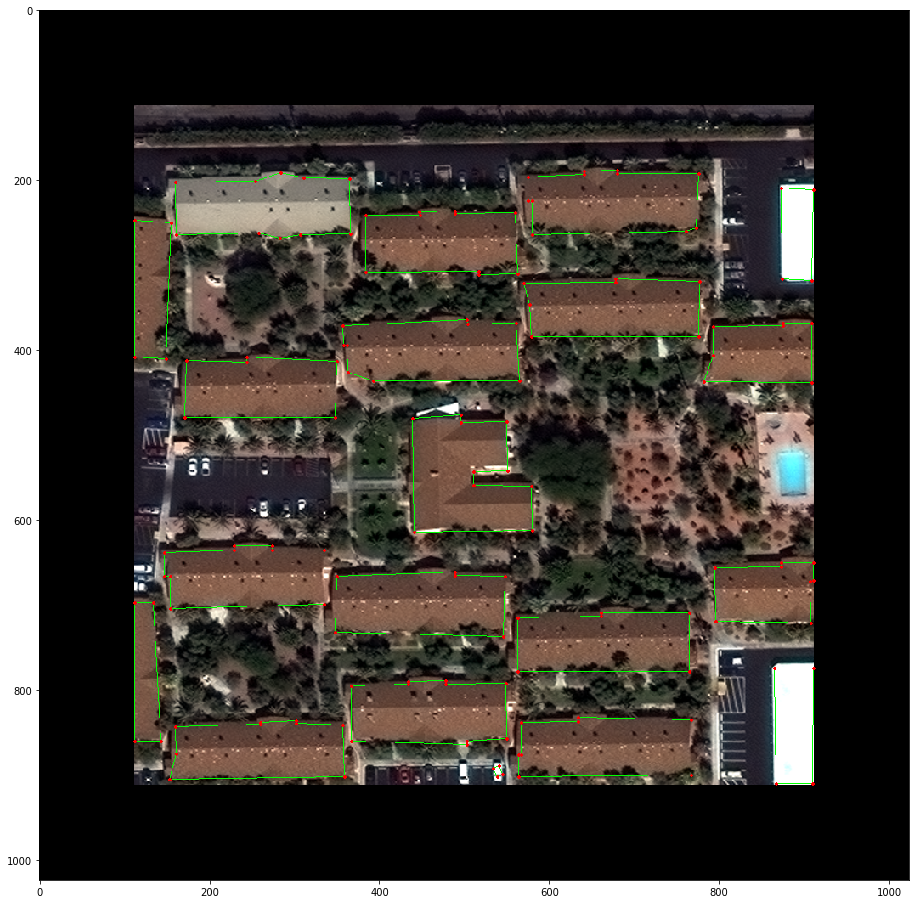

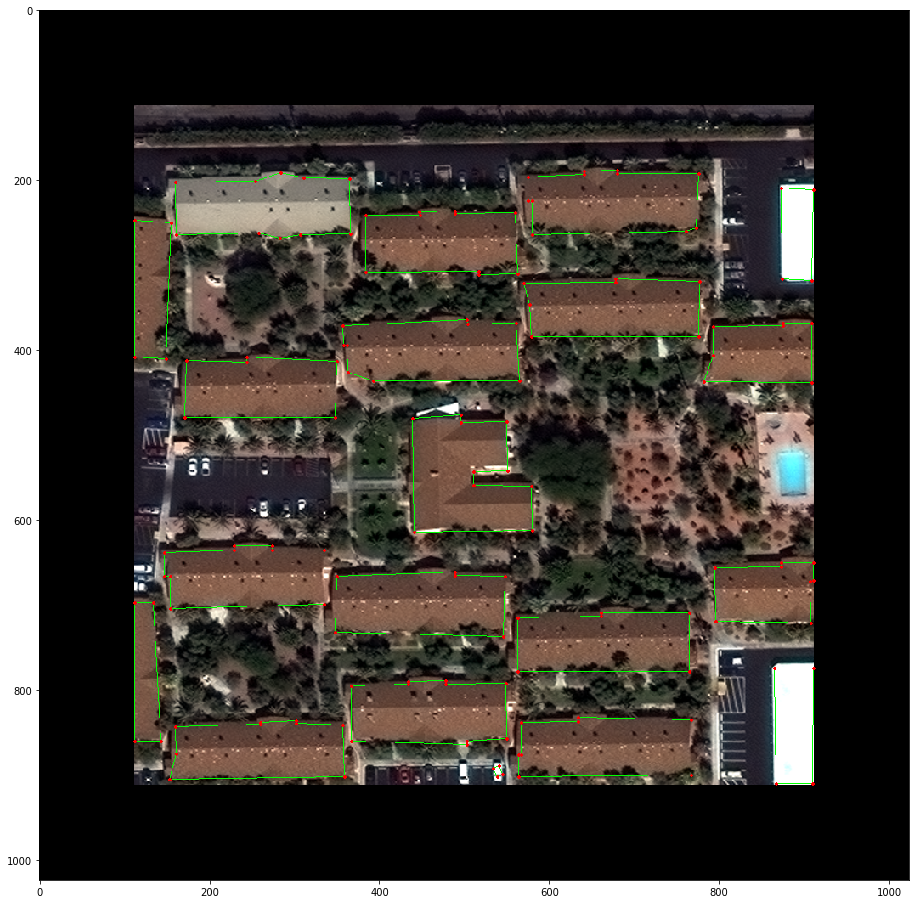

In [125]:
figsize = (16, 16)
plt.figure(figsize=figsize)
plt.imshow(masked_image)
plt.show(0)
output_path_image = output + image_id
skimage.io.imsave(output_path_image+"_poly.jpg", masked_image.astype(np.uint8))

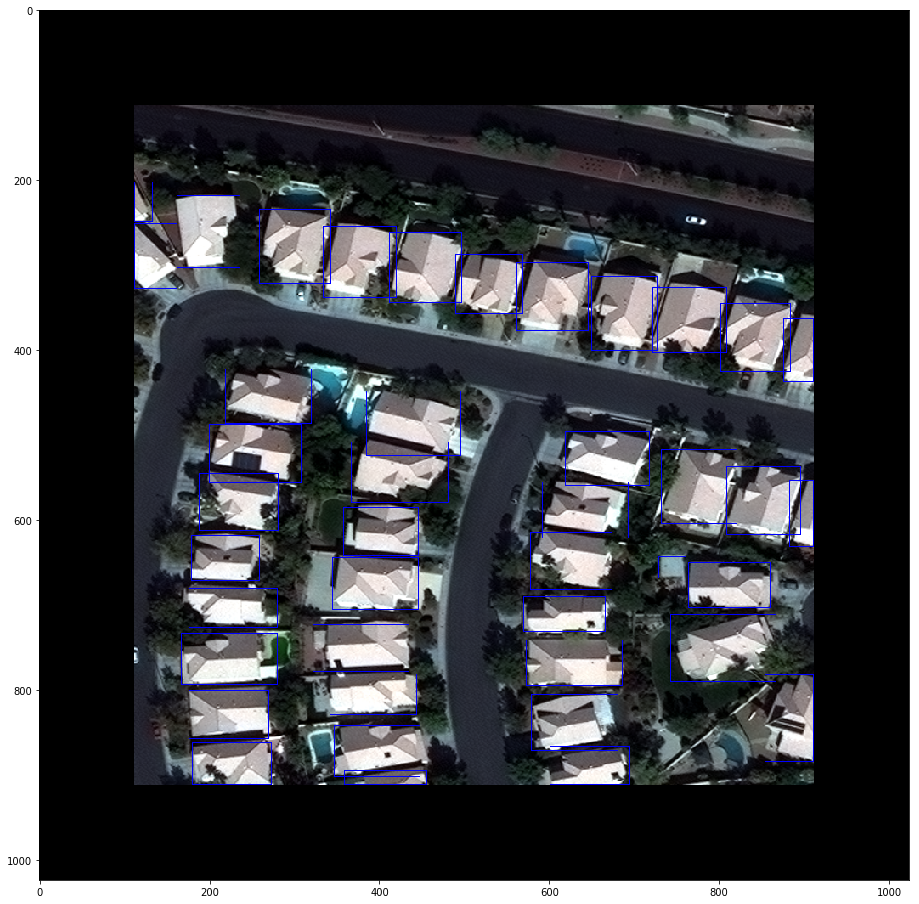

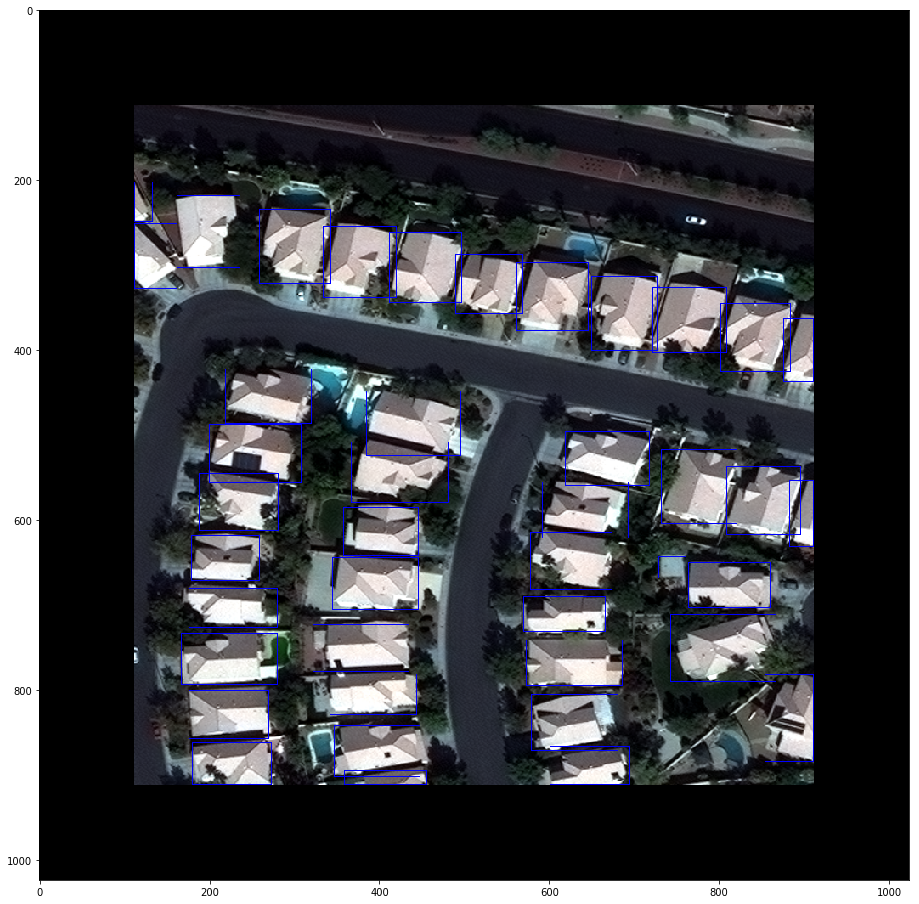

In [14]:
figsize = (16, 16)
plt.figure(figsize=figsize)
plt.imshow(masked_image1)
plt.show(0)
output_path_image = output+ image_id
skimage.io.imsave(output_path_image+"_box.jpg", masked_image1.astype(np.uint8))